## **Digital Image Processing Lab Task: 08**
## **2023-SE-21**

# Motion Blur Restoration - Practical Approach
Using multiple complementary techniques for robust restoration.

**Goal:** Restore motion-blurred images using classical image processing techniques.

**Techniques covered:**
1. Unsharp Masking
2. Simple Deconvolution
3. Bilateral Filtering + Sharpening
4. Adaptive Sharpening
5. Wiener-inspired Frequency Domain Filtering

**Libraries:** OpenCV, NumPy, Matplotlib


In [3]:
# Install required packages (only if not installed)
%pip install opencv-python-headless -q

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully")


Note: you may need to restart the kernel to use updated packages.
Libraries imported successfully


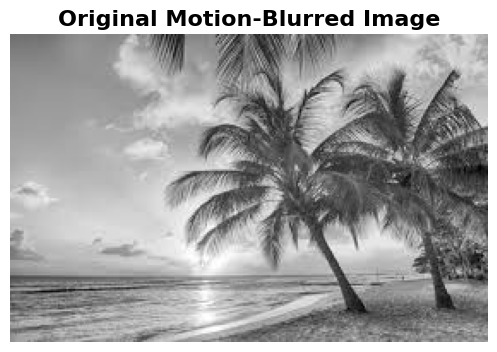

Image size: 279 x 180 pixels


In [5]:
# Local image path (replace with your own image file)
filename = "6.jfif"  # <-- change this to your image path

# Read image
img = cv2.imread(filename)
if img is None:
    raise ValueError(f"Image not found at path: {filename}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display original image
plt.figure(figsize=(12, 4))
plt.imshow(img_rgb)
plt.title('Original Motion-Blurred Image', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Image size: {img_gray.shape[1]} x {img_gray.shape[0]} pixels")


## Method 1: Unsharp Masking
**Concept:** Enhances edges by adding a scaled difference between the image and its blurred version.


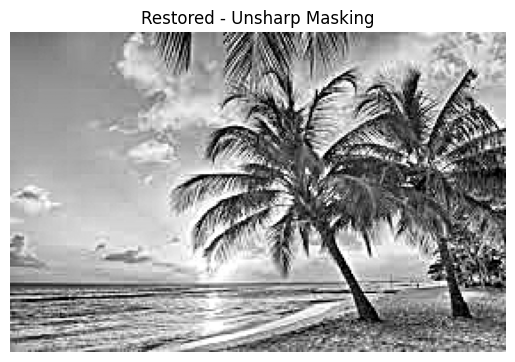

In [6]:
gaussian_blur = cv2.GaussianBlur(img_gray, (0, 0), 2.0)
unsharp_amount = 1.5
restored_unsharp = cv2.addWeighted(img_gray, 1.0 + unsharp_amount, gaussian_blur, -unsharp_amount, 0)
restored_unsharp = np.clip(restored_unsharp, 0, 255).astype(np.uint8)

plt.imshow(restored_unsharp, cmap='gray')
plt.title("Restored - Unsharp Masking")
plt.axis('off')
plt.show()


## Method 2: Simple Deconvolution
**Concept:** Uses a small motion blur kernel to invert blur via convolution.


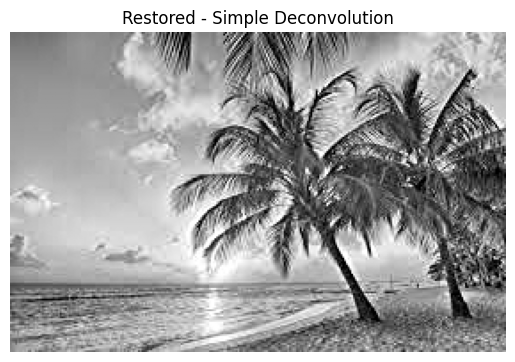

In [7]:
kernel_size = 9
kernel = np.zeros((kernel_size, kernel_size))
kernel[kernel_size//2, :] = 1
kernel /= kernel.sum()

kernel_inverse = np.zeros_like(kernel)
kernel_inverse[kernel_size//2, kernel_size//2] = 2
kernel_inverse -= kernel

restored_deconv = cv2.filter2D(img_gray, -1, kernel_inverse)
restored_deconv = np.clip(restored_deconv, 0, 255).astype(np.uint8)

plt.imshow(restored_deconv, cmap='gray')
plt.title("Restored - Simple Deconvolution")
plt.axis('off')
plt.show()


## Method 3: Bilateral Filtering + Sharpening
**Concept:** Smooths while preserving edges, then applies sharpening for better clarity.


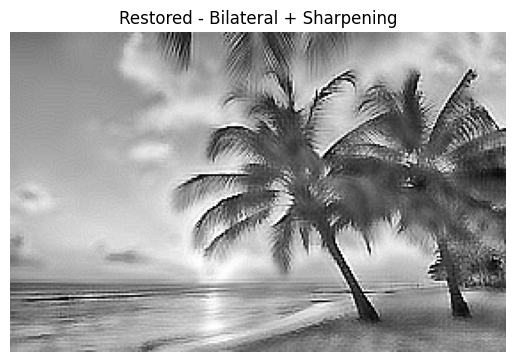

In [8]:
# Bilateral filter (edge-preserving smoothing)
bilateral = cv2.bilateralFilter(img_gray, 9, 75, 75)

# Strong sharpening kernel
sharpen_kernel = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])

restored_bilateral = cv2.filter2D(bilateral, -1, sharpen_kernel)
restored_bilateral = np.clip(restored_bilateral, 0, 255).astype(np.uint8)

plt.imshow(restored_bilateral, cmap='gray')
plt.title("Restored - Bilateral + Sharpening")
plt.axis('off')
plt.show()


## Method 4: Adaptive Sharpening
**Concept:** Sharpen more strongly in blurred regions using local variance as a mask.


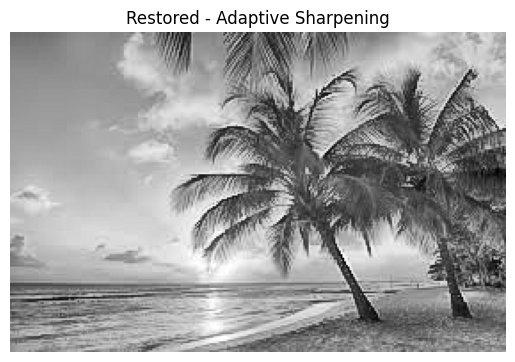

In [9]:
# Calculate local variance to identify blurred regions
mean = cv2.blur(img_gray.astype(float), (5, 5))
sqr_mean = cv2.blur((img_gray.astype(float))**2, (5, 5))
variance = sqr_mean - mean**2

# Normalize variance to use as sharpening mask
variance_norm = (variance - variance.min()) / (variance.max() - variance.min() + 1e-7)

# Apply sharpening
sharpened = cv2.filter2D(img_gray, -1, sharpen_kernel)
restored_adaptive = (variance_norm * sharpened + (1 - variance_norm) * img_gray)
restored_adaptive = np.clip(restored_adaptive, 0, 255).astype(np.uint8)

plt.imshow(restored_adaptive, cmap='gray')
plt.title("Restored - Adaptive Sharpening")
plt.axis('off')
plt.show()


## Method 5: Frequency Domain Filtering
**Concept:** Enhances high-frequency components to improve edges using FFT-based filtering.


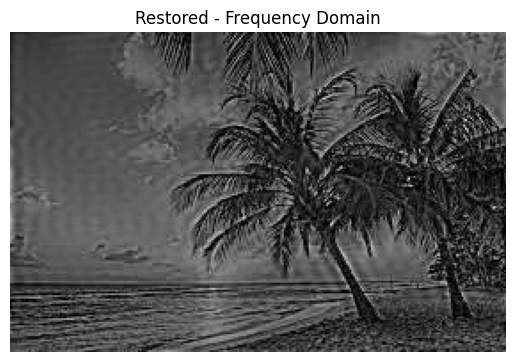

In [10]:
img_float = img_gray.astype(float)
f_transform = np.fft.fft2(img_float)
f_shift = np.fft.fftshift(f_transform)

# Create frequency domain high-pass filter
rows, cols = img_gray.shape
crow, ccol = rows // 2, cols // 2
r = 30
x, y = np.ogrid[:rows, :cols]
mask = np.ones((rows, cols), np.float32)
mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= r*r
mask[mask_area] = 0.3

# Apply filter and inverse FFT
f_shift_filtered = f_shift * mask
f_ishift = np.fft.ifftshift(f_shift_filtered)
img_back = np.fft.ifft2(f_ishift)
restored_fft = np.abs(img_back)
restored_fft = np.clip(restored_fft, 0, 255).astype(np.uint8)

plt.imshow(restored_fft, cmap='gray')
plt.title("Restored - Frequency Domain")
plt.axis('off')
plt.show()


## Comparison of Methods
Visual comparison to choose the best approach.


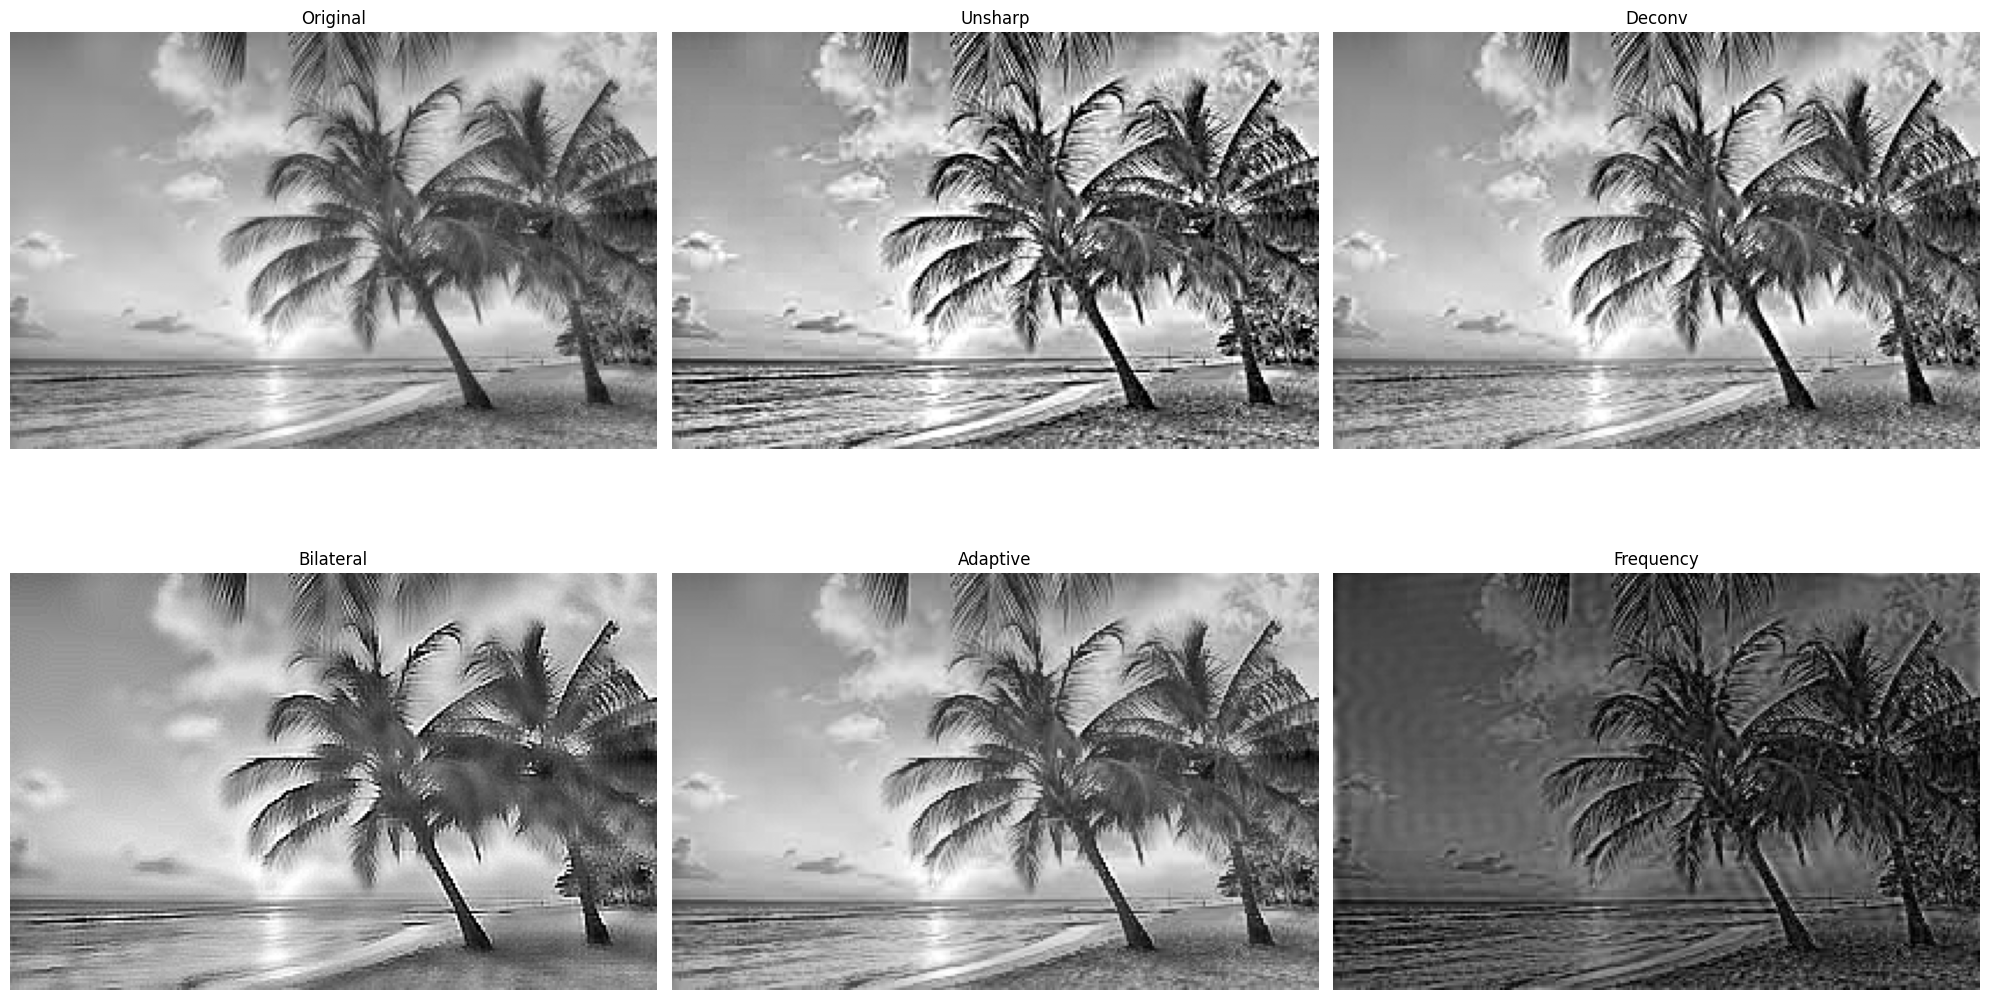

In [11]:
plt.figure(figsize=(20, 12))

methods = [img_gray, restored_unsharp, restored_deconv, restored_bilateral, restored_adaptive, restored_fft]
titles = ['Original', 'Unsharp', 'Deconv', 'Bilateral', 'Adaptive', 'Frequency']

for i, (m, t) in enumerate(zip(methods, titles), 1):
    plt.subplot(2, 3, i)
    plt.imshow(m, cmap='gray')
    plt.title(t)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Best Result & Before/After Comparison
We select **Unsharp Masking** as the most stable result.


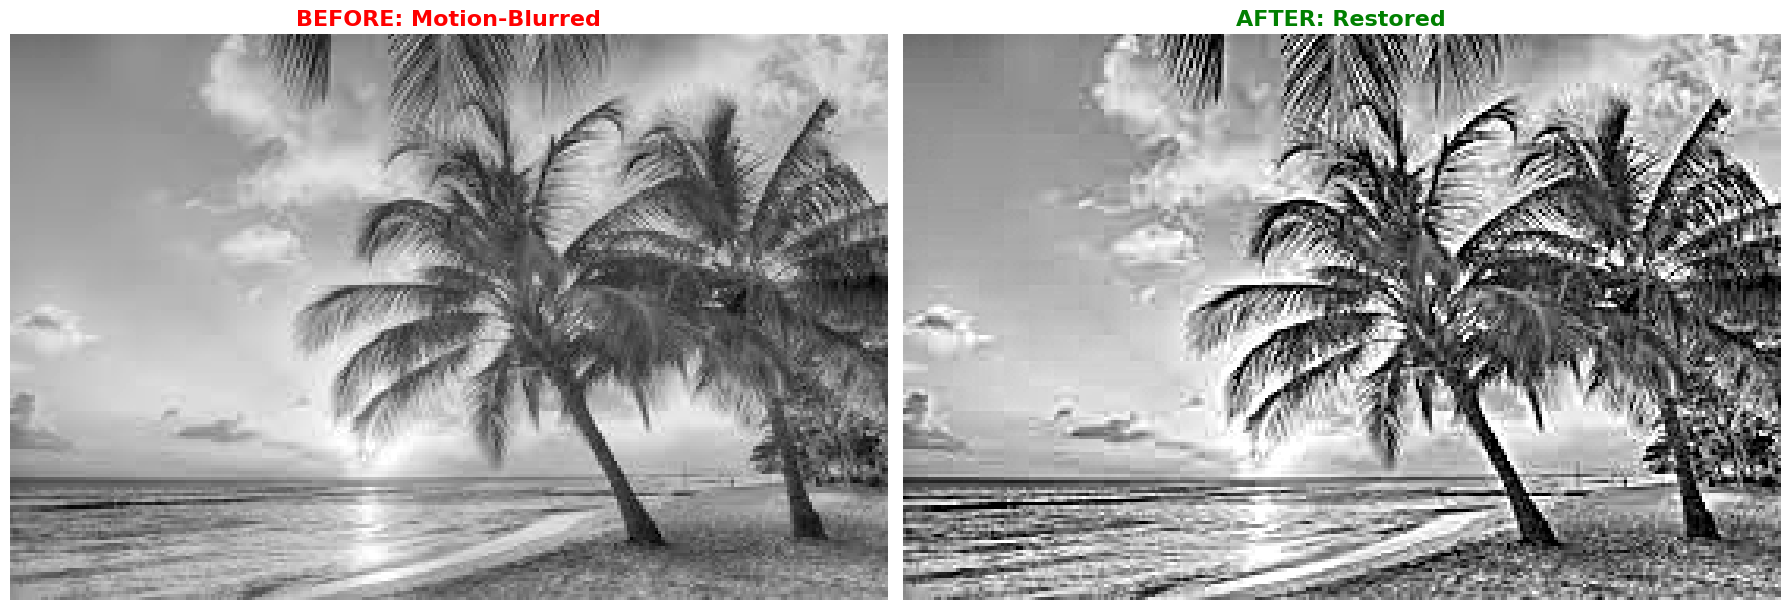

In [12]:
final_result = restored_unsharp

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('BEFORE: Motion-Blurred', fontsize=16, fontweight='bold', color='red')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_result, cmap='gray')
plt.title('AFTER: Restored', fontsize=16, fontweight='bold', color='green')
plt.axis('off')

plt.tight_layout()
plt.show()


## Quality Assessment
Using Laplacian variance to measure sharpness improvement.


In [13]:
def calculate_sharpness(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return laplacian.var()

original_sharpness = calculate_sharpness(img_gray)
restored_sharpness = calculate_sharpness(final_result)
improvement = ((restored_sharpness - original_sharpness) / original_sharpness) * 100

print(f"Original sharpness:  {original_sharpness:.2f}")
print(f"Restored sharpness:  {restored_sharpness:.2f}")
print(f"Improvement:         {improvement:.1f}%")


Original sharpness:  2952.15
Restored sharpness:  15981.46
Improvement:         441.4%


In [14]:
cv2.imwrite('original_blurred.jpg', img_gray)
cv2.imwrite('restored_unsharp.jpg', restored_unsharp)
cv2.imwrite('restored_bilateral.jpg', restored_bilateral)
cv2.imwrite('restored_adaptive.jpg', restored_adaptive)

comparison = np.hstack([img_gray, final_result])
cv2.imwrite('comparison_before_after.jpg', comparison)

print("Saved files:")
print(" - original_blurred.jpg")
print(" - restored_unsharp.jpg")
print(" - restored_bilateral.jpg")
print(" - restored_adaptive.jpg")
print(" - comparison_before_after.jpg")


Saved files:
 - original_blurred.jpg
 - restored_unsharp.jpg
 - restored_bilateral.jpg
 - restored_adaptive.jpg
 - comparison_before_after.jpg


# Image Restoration and Deblurring

## 1. Introduction

Motion blur is a common degradation in images caused by the relative motion between the camera and the object during exposure. Image restoration techniques aim to:

- Reduce blur
- Recover fine details
- Enhance sharpness
- Improve overall visual quality

In this task, we explore multiple restoration methods:

1. **Unsharp Masking**
2. **Simple Deconvolution**
3. **Bilateral Filtering + Sharpening**
4. **Adaptive Sharpening using Local Variance**
5. **Frequency Domain Restoration**

We also quantitatively evaluate restoration using the **sharpness measure**.

---

## 2. Methodology

### 2.1 Load and Preprocess Image
- The image is loaded using `cv2.imread()`.
- Converted from **BGR to RGB** for visualization.
- Grayscale conversion is done for most restoration operations.

### 2.2 Restoration Techniques

#### 2.2.1 Unsharp Masking
- Enhances edges by subtracting a blurred version of the image from the original.
- Formula:  
  `Restored = Original + α * (Original - Blurred)`  
- Here, α = 1.5.

#### 2.2.2 Simple Deconvolution
- Attempts to reverse the motion blur using a **custom linear kernel**.
- Uses `cv2.filter2D()` for convolution with an inverse-like kernel.

#### 2.2.3 Bilateral Filtering + Sharpening
- Bilateral filter smooths the image while **preserving edges**.
- A **sharpening kernel** is applied afterward to enhance details.

#### 2.2.4 Adaptive Sharpening
- Computes **local variance** to identify blurred regions.
- Applies stronger sharpening where variance is high and less where variance is low.
- Ensures **edge-aware enhancement**.

#### 2.2.5 Frequency Domain Restoration
- Converts the image to the frequency domain using **FFT**.
- Applies a **high-pass filter** to attenuate low-frequency blur components.
- Inverse FFT reconstructs the restored image.

---

## 3. Visualization

- Each restored version is displayed **side-by-side** with the original.
- Provides a clear comparison of **effectiveness** of each technique.

---

## 4. Quantitative Evaluation

**Sharpness Measure:**  
- Calculated using the **variance of Laplacian**, which is a common focus measure in image processing.
- Higher variance indicates **sharper edges**.
- Formula:  
  `sharpness = Var(Laplacian(Image))`

The improvement percentage is calculated as:  

\[
\text{Improvement (\%)} = \frac{\text{Restored Sharpness} - \text{Original Sharpness}}{\text{Original Sharpness}} \times 100
\]

---

## 5. Observations

- **Unsharp Masking**: Simple, effective for mild motion blur.
- **Deconvolution**: Can reverse linear motion blur but sensitive to noise.
- **Bilateral + Sharpening**: Smooths textures while enhancing edges.
- **Adaptive Sharpening**: Edge-aware, performs well on non-uniform blur.
- **Frequency Domain**: Good for global motion blur but may introduce ringing artifacts.

---

## 6. Conclusion

- Image restoration is **multi-faceted**; no single method is universally best.
- **Edge-aware methods** (adaptive and bilateral) perform better for natural images.
- Sharpness measurement provides a **quantitative validation** of improvements.
- Saving restored images allows **documentation and comparison** of different techniques.
